In [38]:
import numpy as np
from hem.HEM_v0 import aec_env, parallel_env, sa_env
import yaml
from hem.env.utils import Renderer
from pettingzoo.test import api_test, parallel_api_test
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from hem.env.utils import Renderer

import supersuit as ss

In [39]:
config_path = 'hem/env/config_env.yaml'
env_config = yaml.safe_load(open(config_path, 'r', encoding='utf-8'))

env_attr = {
    'random_episode_split': True,
    'rolling_episode_split': False,
    'data_start_end': (24 * 60 * 2, 6 * 24 * 60 + 1),  # 数据集中，一共6，7，8，9月，122天，1分钟一个数据点
    'episode_time_steps': int(24 * 60 / env_config['MINUTES_PER_TIME_STEP']),  # one day, 24 hours
    'mode': 'train',
    'random_seed': 1,
    'noise_strength': 0,
    'config_path': config_path,
    'render_mode': 'None',
}

In [40]:
env = parallel_env(**env_attr)
env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 14, num_cpus=14, base_class="stable_baselines3")

model = PPO(
    MlpPolicy,
    env,
    verbose=3,
    learning_rate=1e-3,
    batch_size=256,
)

model.learn(total_timesteps=1000_000)

agent_num = len(env.unwrapped.possible_agents)

Make env: mode: train, whole_days: 4, train_days: 4, val_days: 0, test_days: 0
Using cpu device
------------------------------
| time/              |       |
|    fps             | 48546 |
|    iterations      | 1     |
|    time_elapsed    | 1     |
|    total_timesteps | 86016 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 29048        |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 172032       |
| train/                  |              |
|    approx_kl            | 0.0053171357 |
|    clip_fraction        | 0.0614       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.49        |
|    explained_variance   | 0.00025      |
|    learning_rate        | 0.001        |
|    loss                 | 4.57e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00135     |

Make env: mode: train, whole_days: 4, train_days: 4, val_days: 0, test_days: 0
Episode Time: (0, 287)


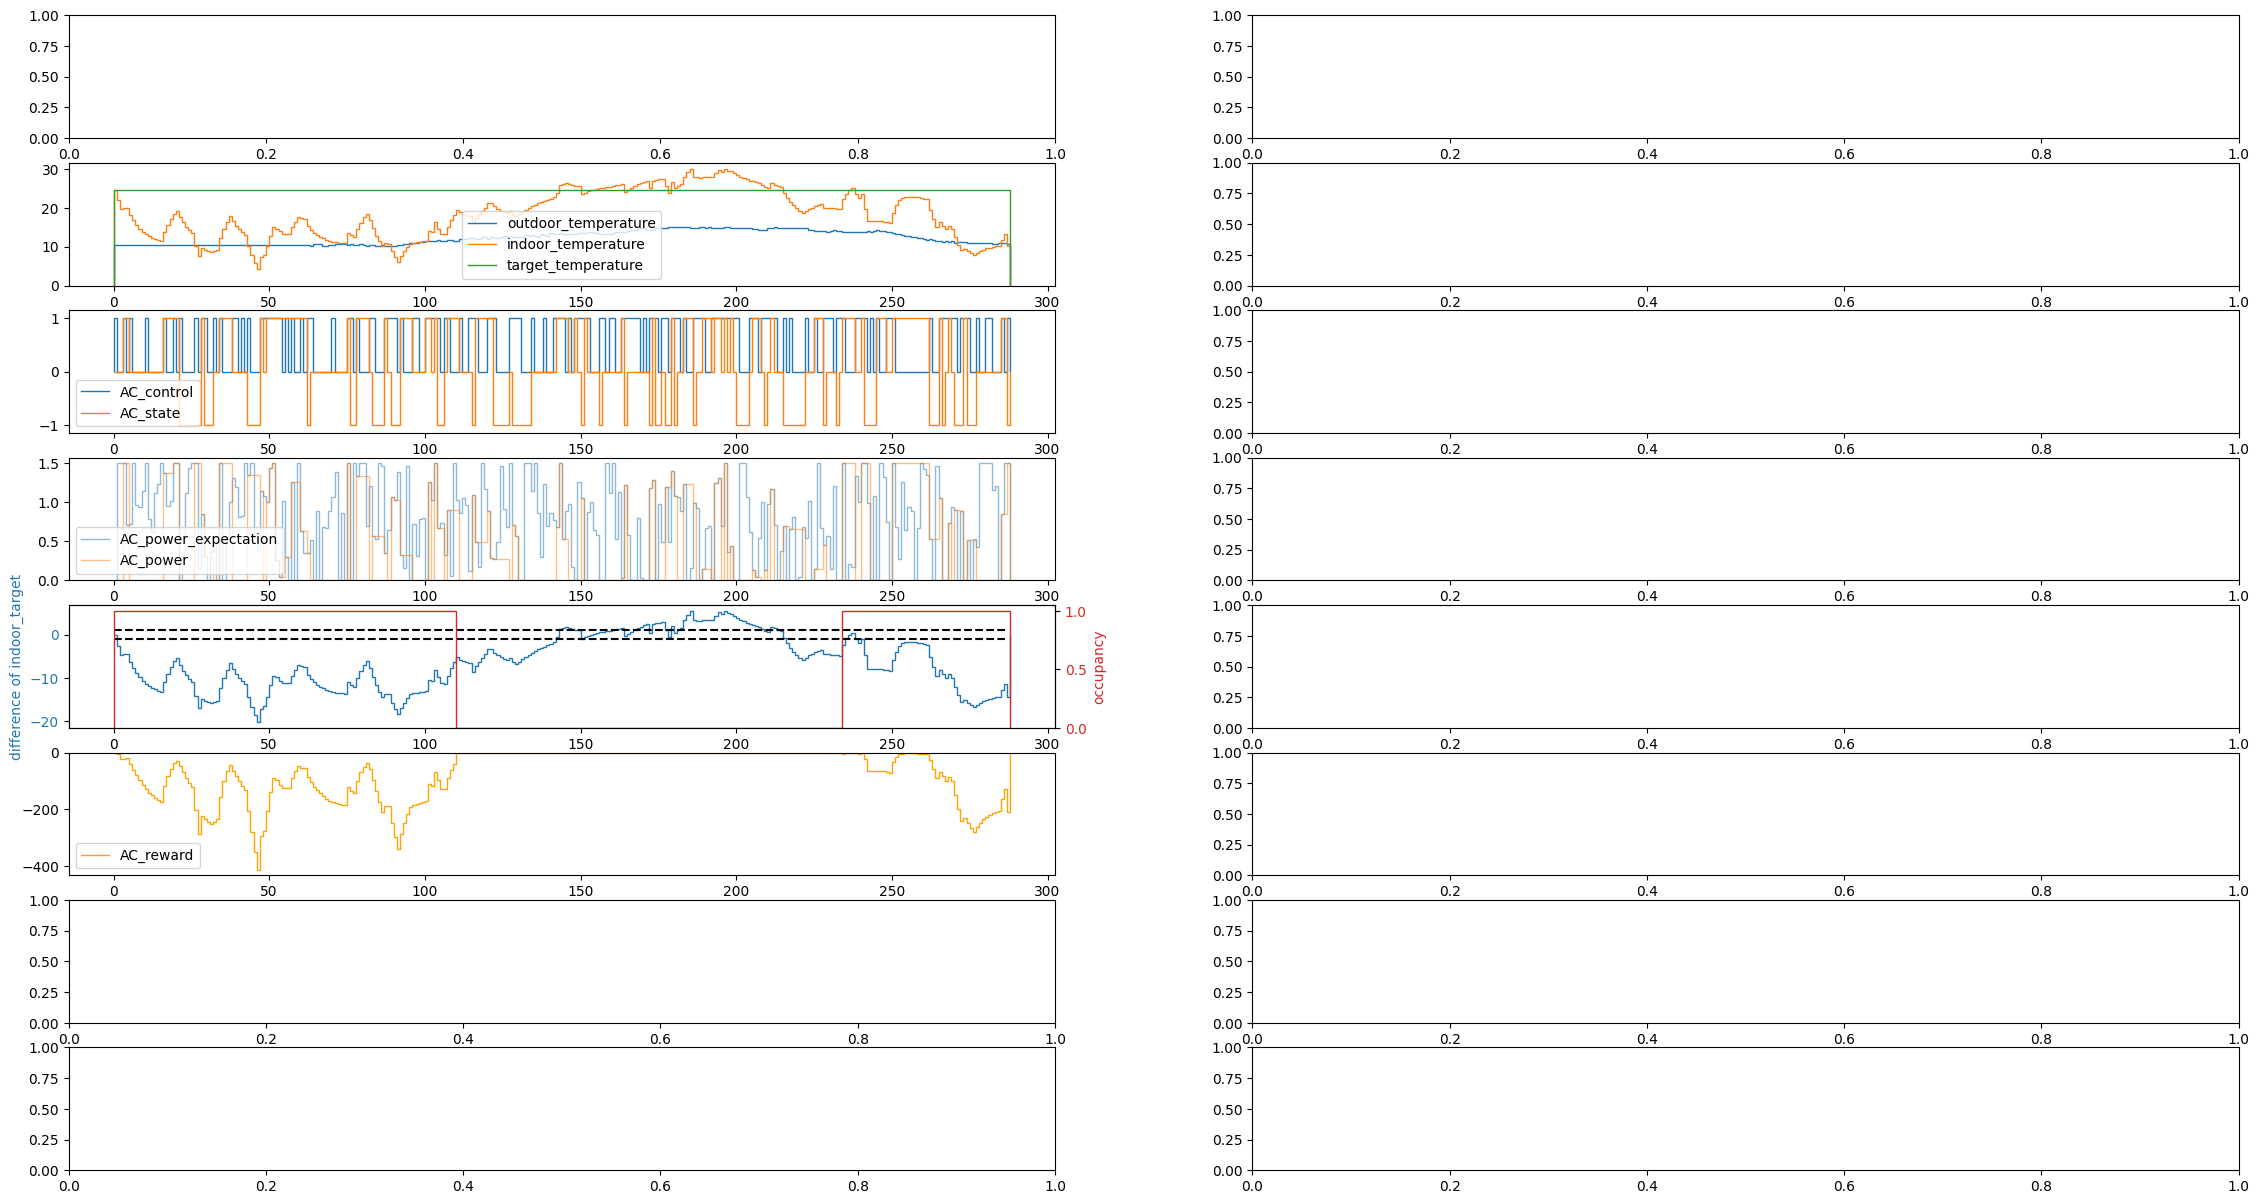

Episode Time: (288, 575)


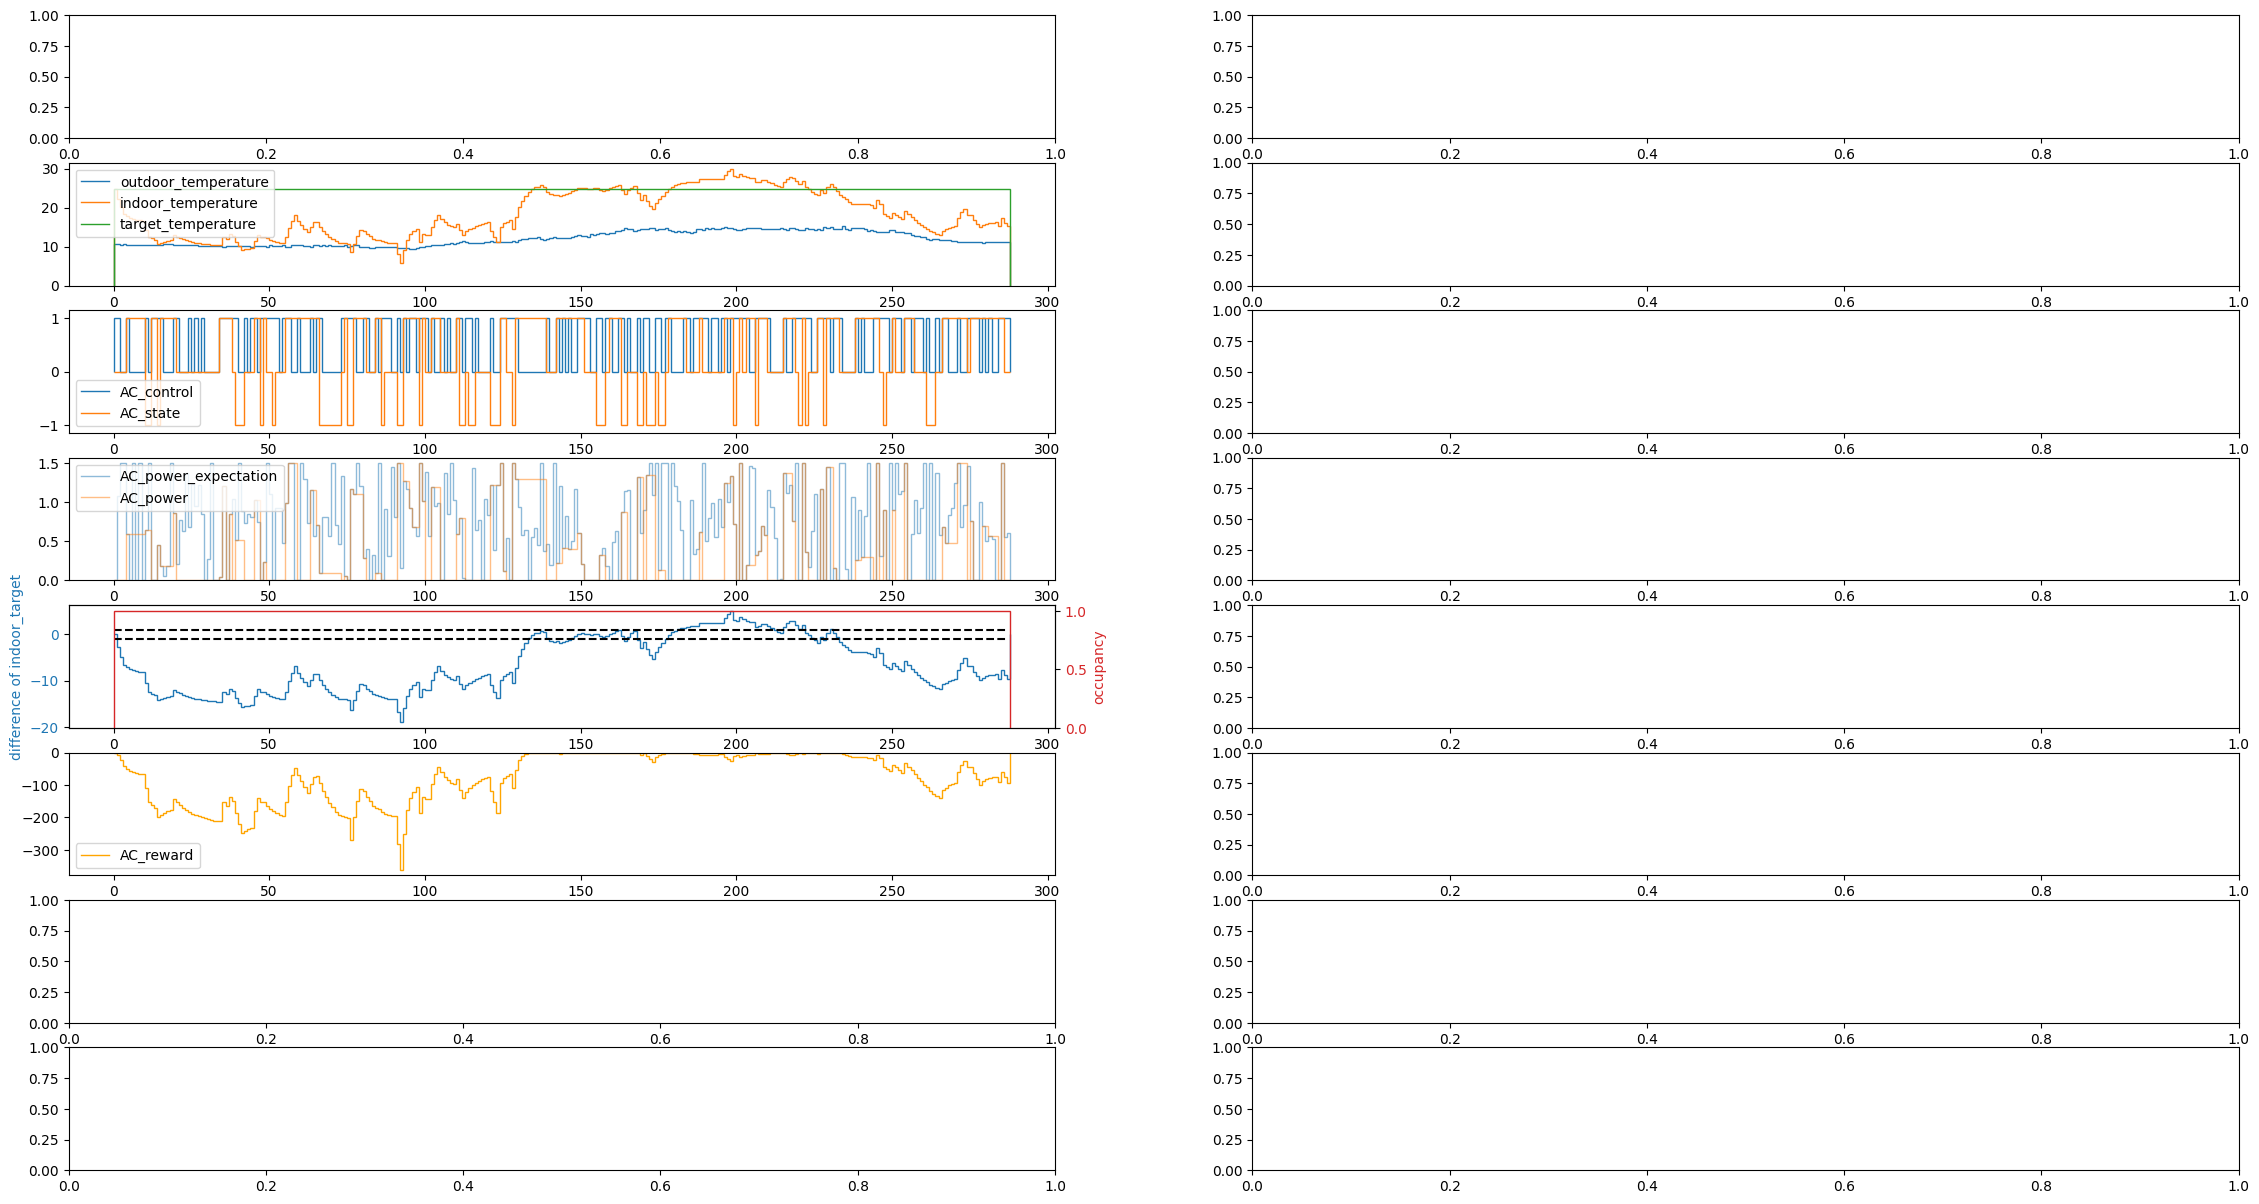

Episode Time: (576, 863)


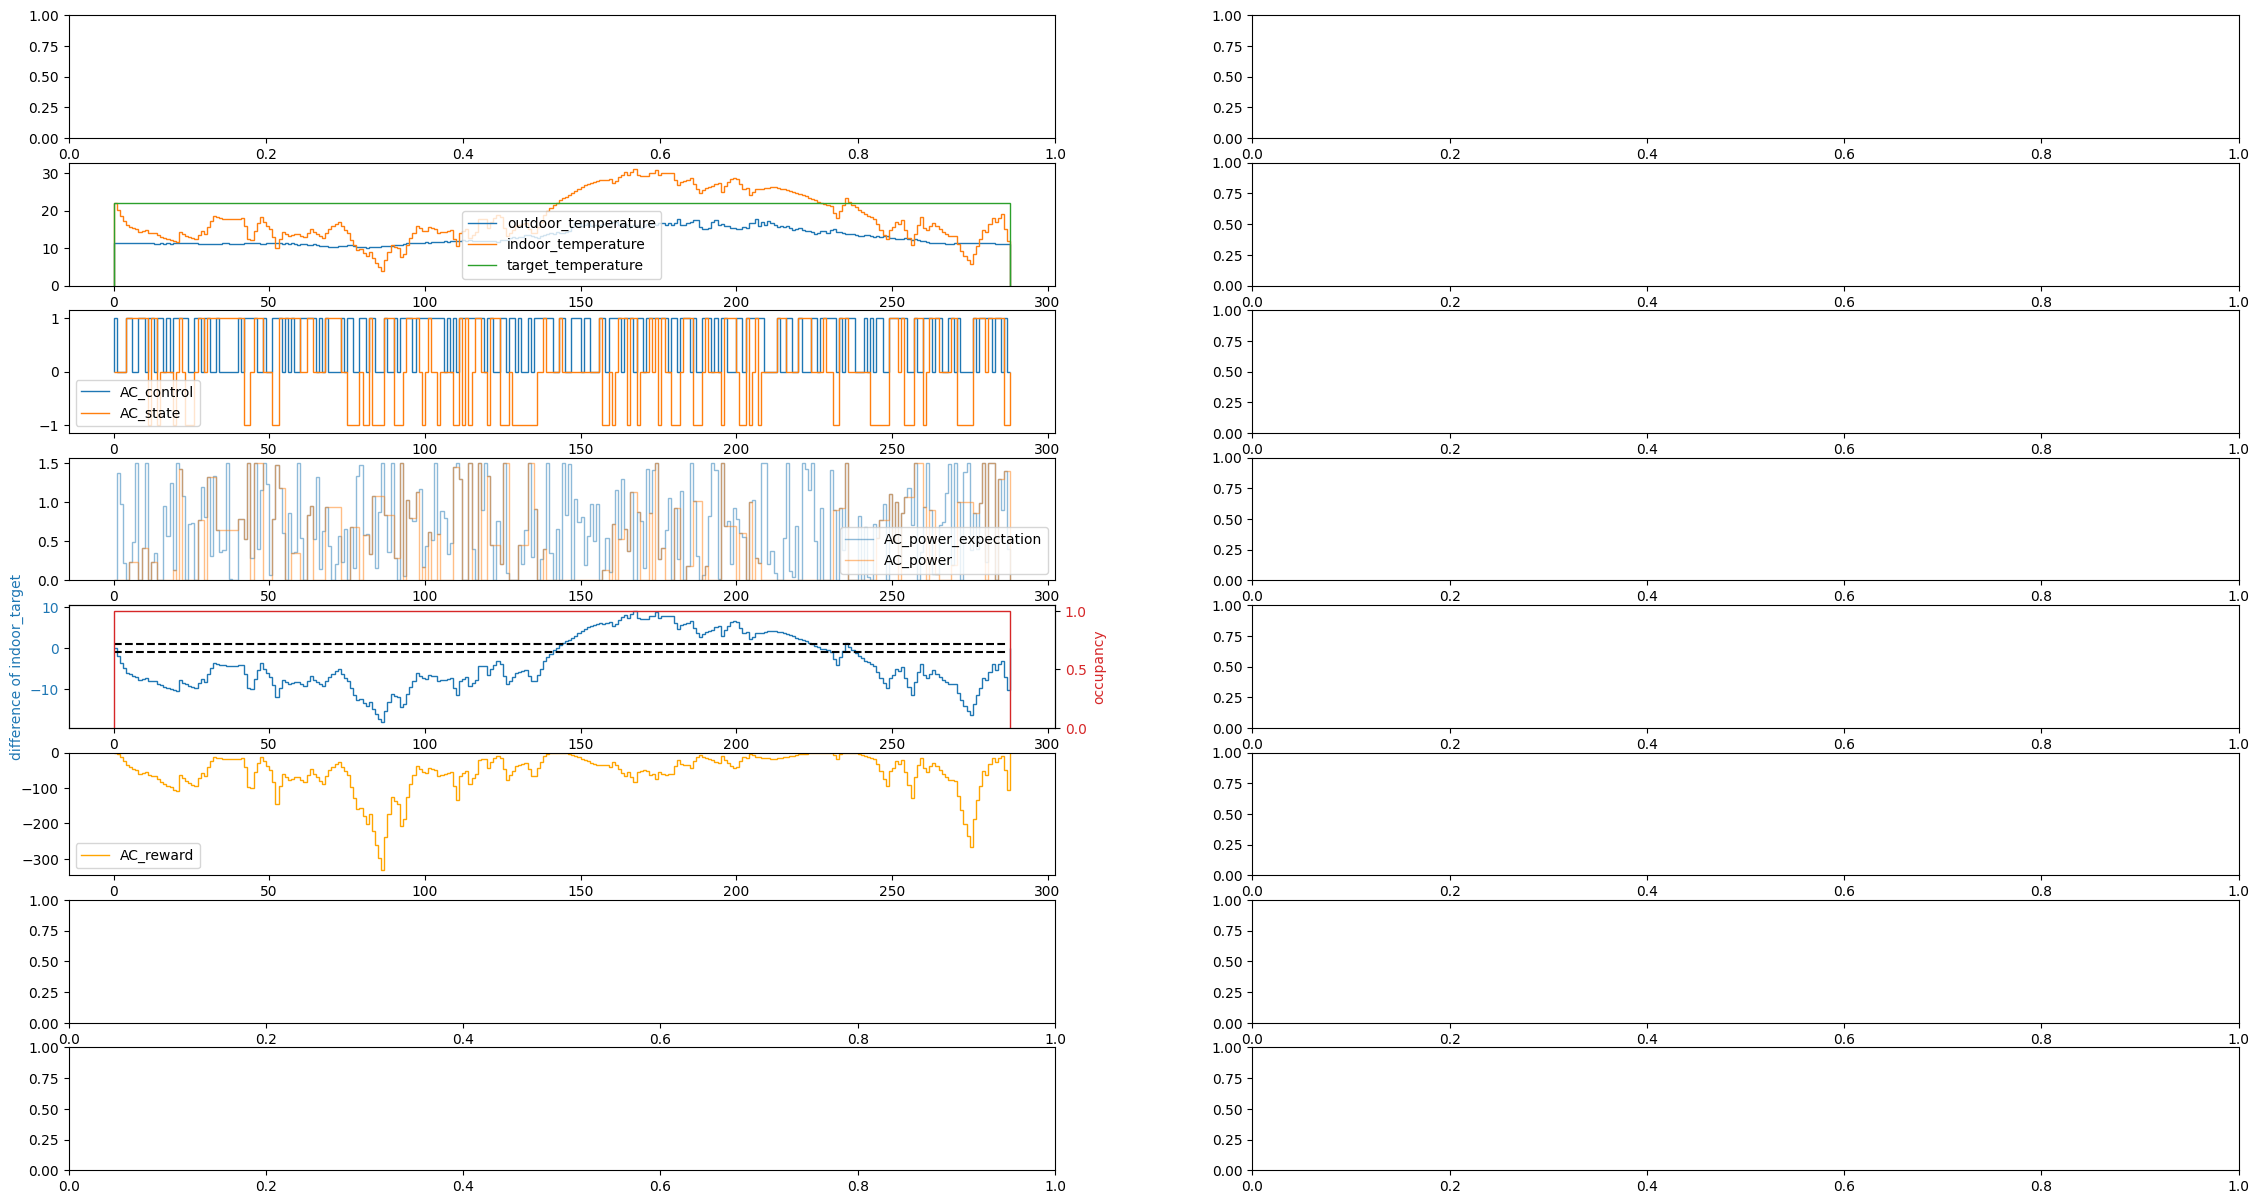

Episode Time: (864, 1151)


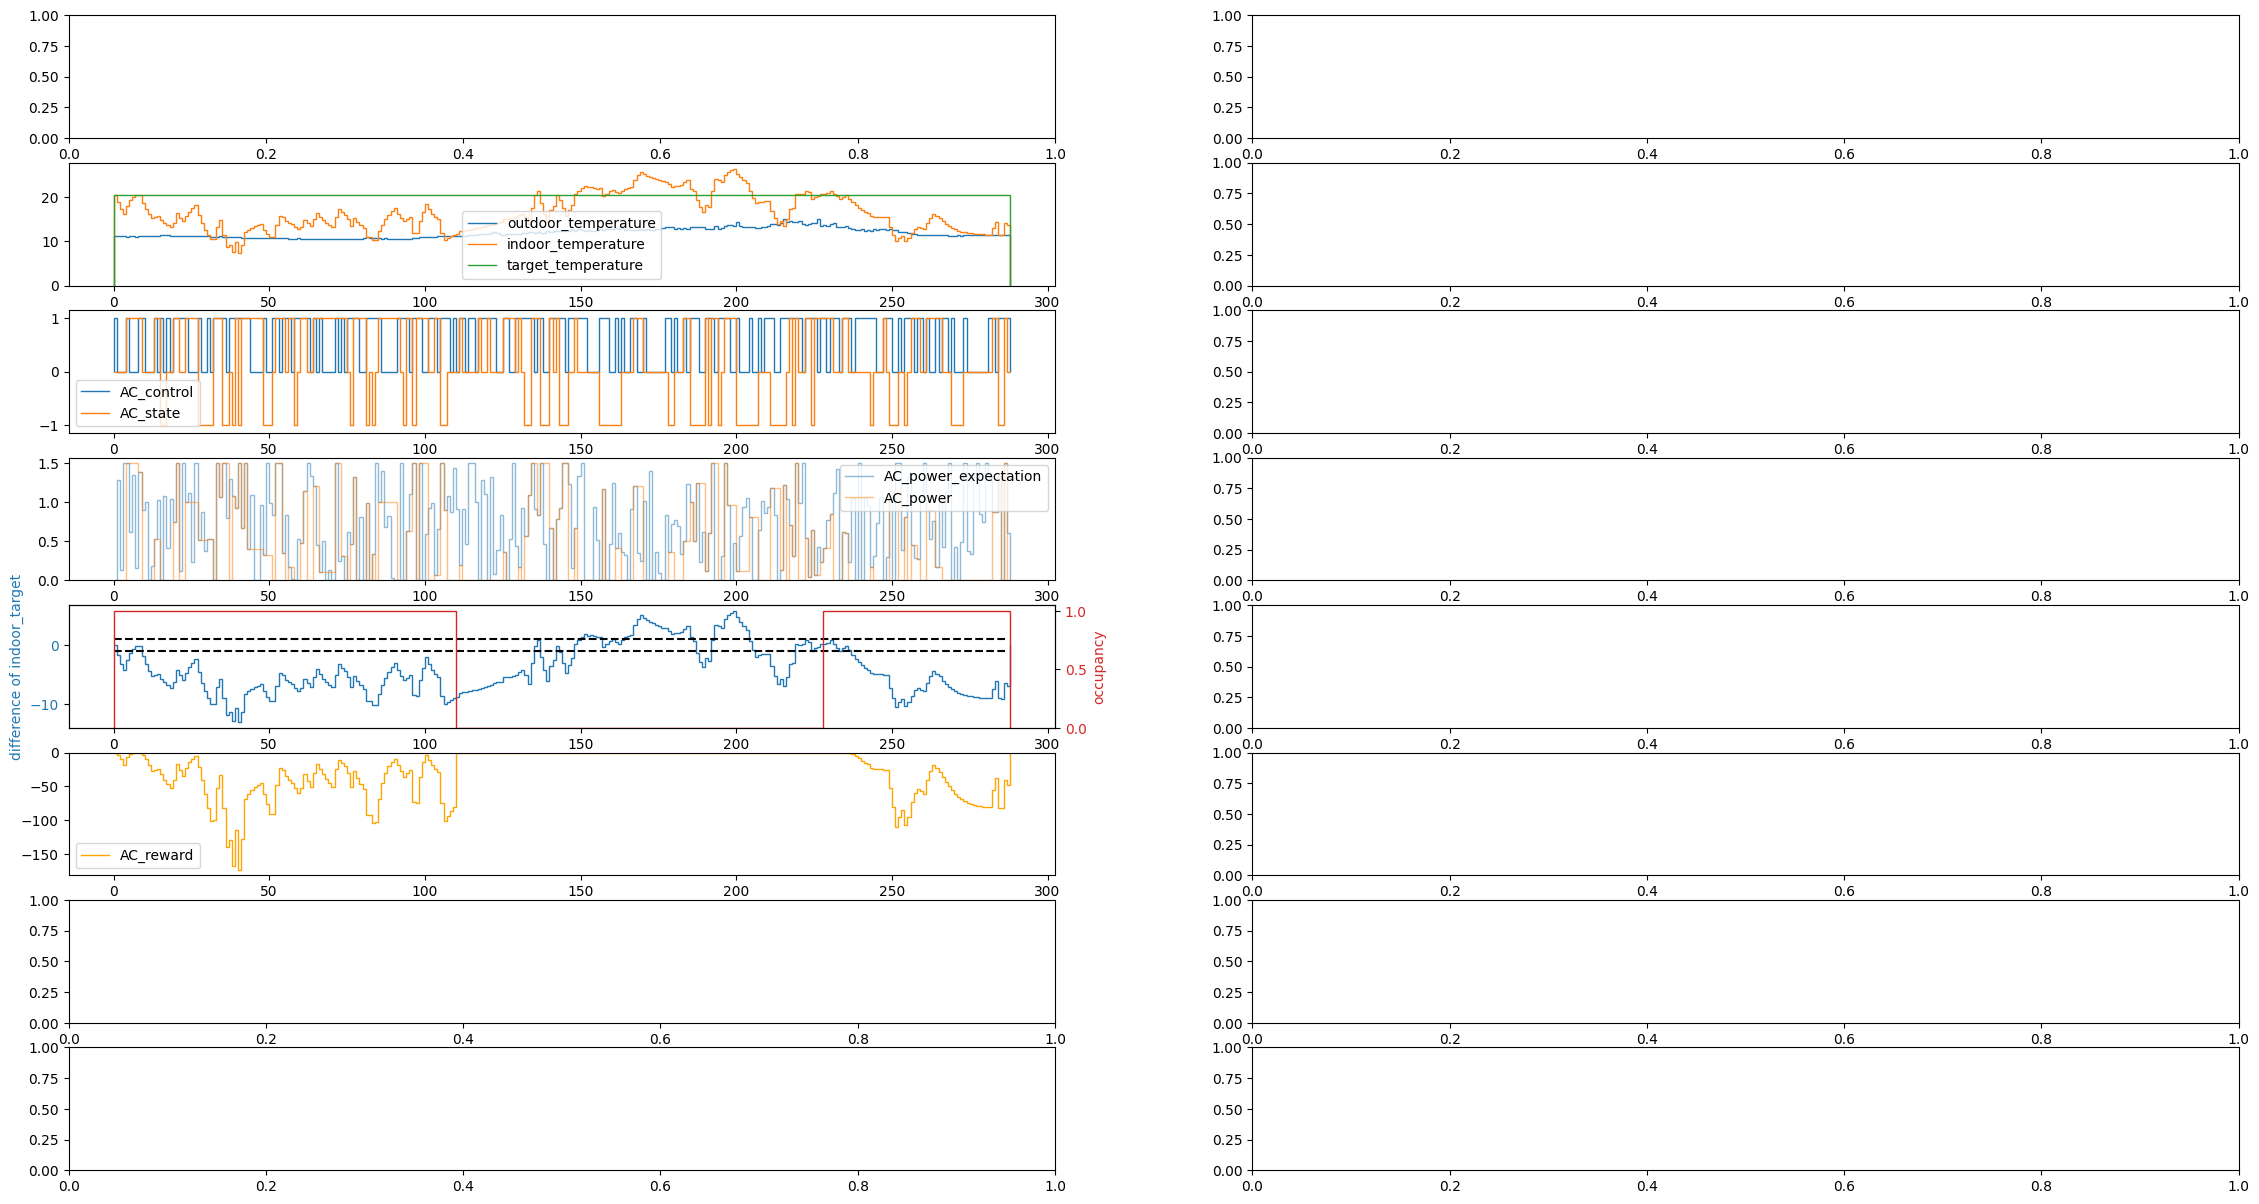

In [41]:
env_attr['random_episode_split'] = False

env = parallel_env(**env_attr)
env = ss.pettingzoo_env_to_vec_env_v1(env)
renderer = Renderer(render_mode='episode', env=env.par_env.unwrapped)

observation, infos = env.reset()
for e in range(4):
    renderer.reset()
    terminations = [False]
    truncations = [False]
    while not any(terminations) and not any(truncations):
        actions, _ = model.predict(observation)
        observation, rewards, terminations, truncations, infos = env.step(actions)
        renderer.collect()
    renderer.render()